# Mount Drive

This section is only if you are working in Google Colab as you will need to mount your Google Drive to the notebook for access to the dataset stored in your Google Drive

In [1]:
# Mount data from drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Import Libraries

In [2]:
# install keras-vggface library
!pip install keras-vggface

# dependencies for keras-vggface to work
!pip install keras_applications
!pip install keras_preprocessing

# use Multi-Task Cascaded CNN (MTCNN) for face detection
# eg find and extract faces from photos
# state of art deep learnnig model for face detection in 2016
# install the mtcnn package
!pip install mtcnn

# package to plot deep learning models
!pip install visualkeras

# replace from keras.engine.topology import get_source_inputs to from keras.utils.layer_utils import get_source_inputs
# in models.py for keras-vggface to work
filename = "/usr/local/lib/python3.7/dist-packages/keras_vggface/models.py"
text = open(filename).read()
open(filename, "w+").write(text.replace('keras.engine.topology', 'keras.utils.layer_utils'))

# dlib library: dlib is built through pre-trained models to locate the facial landmarks
!pip install dlib
# face_recognition library: face_recognition is an open-source project, 
# which is also known as the most straightforward API for facial recognition
!pip install face_recognition

     |████████████████████████████████| 50 kB 4.6 MB/s 
     |████████████████████████████████| 2.3 MB 8.8 MB/s 
     |████████████████████████████████| 795 kB 9.7 MB/s 
     |████████████████████████████████| 100.1 MB 13 kB/s 
  Created wheel for face-recognition-models: filename=face_recognition_models-0.3.0-py2.py3-none-any.whl size=100566185 sha256=b130473f5e5fd4c27108726eeac9586bc96d3b70fe1ab049454de1629a7ff50c
  Stored in directory: /root/.cache/pip/wheels/d6/81/3c/884bcd5e1c120ff548d57c2ecc9ebf3281c9a6f7c0e7e7947a
Successfully built face-recognition-models


In [16]:
import matplotlib.pyplot as plt
from PIL import Image
from numpy import asarray
from scipy.spatial.distance import cosine
from mtcnn.mtcnn import MTCNN
from keras_vggface.vggface import VGGFace
from keras_vggface.utils import preprocess_input
import os

# import the necessary packages
from collections import deque
import numpy as np

# Example of face detection with a vggface2 model
from numpy import expand_dims
from mtcnn.mtcnn import MTCNN

import cv2
# import face_recognition
from google.colab.patches import cv2_imshow#, cv2_imread

from tensorflow.keras.layers import Flatten, Dense, Input, Dropout, GlobalAveragePooling2D
from tensorflow.keras import Model

import random
import pandas as pd

## Google Colab to change directory to current working directory

This section is only if you are working in Google Colab to change to your current working directory so you can access the dataset.

PLEASE NOTE that the data path specified in this notebook is only valid for working in Google Colab. YOU WILL. NEED TO EDIT THE PATH ACCORDINGLY to where your dataset or your folders are.

In [4]:
cd drive/MyDrive/Colab\ Notebooks/GA-Capstone/

/content/drive/MyDrive/Colab Notebooks/GA-Capstone


In [5]:
capstone_dir = os.getcwd()

In [6]:
capstone_dir

'/content/drive/MyDrive/Colab Notebooks/GA-Capstone'

# Prepare Model

## Function for preparing the models for classification and face embedding to compute similarily probability of faces

In [7]:
def prepare_embedding_model(layers_dims, layers_name, num_class, model_weights, dropout_value=None, dropout_name=None):
  #custom parameters

  # nb_class = 100
  # hidden_dim = 512

  # specify input for custom model, model -> resnet50, senet50, vgg16
  vgg_model = VGGFace(model='vgg16', include_top=False, input_shape=(224, 224, 3))
  # last_layer = vgg_model.get_layer('avg_pool').output

  last_layer = vgg_model.output
  x = Flatten(name='flatten')(last_layer)

  if dropout_name and dropout_value:
    for dims, layer, value, name in zip(layers_dims, layers_name[:-1], dropout_value, dropout_name):
      x = Dense(dims, activation='relu', name=layer)(x)
      x = Dropout(value, name=name)(x)
  else:
    for dims, layer in zip(layers_dims, layers_name[:-1]):
      x = Dense(dims, activation='relu', name=layer)(x)
      # for value, name in zip(dropout_value, dropout_name):
      #   print(name)
        
  
  out = Dense(num_class, activation='softmax', name=layers_name[-1])(x)
  
  # # freeze all pre train model layers
  # for layer in vgg_model.layers:
  #   layer.trainable = False

  # instantiate custom model by passing inputs and outputs
  custom_vgg_model = Model(inputs=vgg_model.input, outputs=out)

  # load pre-trained model weights
  custom_vgg_model.load_weights(model_weights)

  # remove last layer
  custom_vgg_model = Model(inputs=custom_vgg_model.input, outputs=custom_vgg_model.get_layer('pool5').output)
  custom_vgg_model_last_layer = custom_vgg_model.output

  # attach global avg pooling to last layer
  custom_vgg_model_out = GlobalAveragePooling2D(name='avg_pooling')(custom_vgg_model_last_layer)

  # # instantiate custom model by passing inputs and outputs
  custom_vgg_model = Model(inputs=custom_vgg_model.input, outputs=custom_vgg_model_out)

  # compile model
  custom_vgg_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

  return custom_vgg_model


def prepare_model(layers_dims, layers_name, num_class, model_weights, dropout_value=None, dropout_name=None):
  #custom parameters

  # nb_class = 100
  # hidden_dim = 512

  # specify input for custom model, model -> resnet50, senet50, vgg16
  vgg_model = VGGFace(model='vgg16', include_top=False, input_shape=(224, 224, 3))
  # last_layer = vgg_model.get_layer('avg_pool').output

  last_layer = vgg_model.output
  x = Flatten(name='flatten')(last_layer)

  if dropout_name and dropout_value:
    for dims, layer, value, name in zip(layers_dims, layers_name[:-1], dropout_value, dropout_name):
      x = Dense(dims, activation='relu', name=layer)(x)
      x = Dropout(value, name=name)(x)
  else:
    for dims, layer in zip(layers_dims, layers_name[:-1]):
      x = Dense(dims, activation='relu', name=layer)(x)
      # for value, name in zip(dropout_value, dropout_name):
      #   print(name)
        
  
  out = Dense(num_class, activation='softmax', name=layers_name[-1])(x)
  
  # # freeze all pre train model layers
  # for layer in vgg_model.layers:
  #   layer.trainable = False

  # instantiate custom model by passing inputs and outputs
  custom_vgg_model = Model(inputs=vgg_model.input, outputs=out)

  # load pre-trained model weights
  custom_vgg_model.load_weights(model_weights)

  
  # compile model
  custom_vgg_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

  return custom_vgg_model

## Model for classification

In [8]:
# # number of classification class
num_class = 100

# path for the model weights
model5_path = "model_checkpoint/vgg/model5/weights.epoch13-0.9735-0.7499acc.hdf5"
# dropout layer value
model5_dropout_value = [0.3, 0.3, 0.3]
# number of nodes for each fully connected layer
model5_layers_dims = [256, 256, 256]
# dropout layer name
three_layers_dropout_name = ['drop1', 'drop2', 'drop3']
# layers name for the classification block
# 3 hidden + 1 output
three_layers_name = ['fc6', 'fc7', 'fc8', 'fc9']

In [9]:
model = prepare_model(layers_dims=model5_layers_dims, layers_name=three_layers_name, num_class=num_class, 
                      model_weights=model5_path, dropout_value=model5_dropout_value,
                      dropout_name=three_layers_dropout_name)

58925056/58909280 [==============================] - 0s 0us/step


In [10]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_1 (Conv2D)             (None, 224, 224, 64)      1792      
_________________________________________________________________
conv1_2 (Conv2D)             (None, 224, 224, 64)      36928     
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 112, 112, 64)      0         
_________________________________________________________________
conv2_1 (Conv2D)             (None, 112, 112, 128)     73856     
_________________________________________________________________
conv2_2 (Conv2D)             (None, 112, 112, 128)     147584    
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 56, 56, 128)       0     

## Model for face embedding

In [11]:
model_embedding = prepare_embedding_model(layers_dims=model5_layers_dims, layers_name=three_layers_name, num_class=num_class, 
                                          model_weights=model5_path, dropout_value=model5_dropout_value,
                                          dropout_name=three_layers_dropout_name)

In [12]:
model_embedding.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_1 (Conv2D)             (None, 224, 224, 64)      1792      
_________________________________________________________________
conv1_2 (Conv2D)             (None, 224, 224, 64)      36928     
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 112, 112, 64)      0         
_________________________________________________________________
conv2_1 (Conv2D)             (None, 112, 112, 128)     73856     
_________________________________________________________________
conv2_2 (Conv2D)             (None, 112, 112, 128)     147584    
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 56, 56, 128)       0   

In [13]:
labels = [
  'Alexandre_Lacazette',
  'Alexis_Sanchez',
  'Alisson_Becker',
  'Angel_di_Maria',
  'Antoine_Griezmann',
  'Bernando_Silva',
  'Bernd_Leno',
  'Carles_Puyol',
  'Carlos_Tevez',
  'Chrisitan_Pulisic',
  'Christian_Eriksen',
  'Cristiano_Ronaldo',
  'David_Beckham',
  'David_Luiz',
  'David_Silva',
  'Didier_Drogba',
  'Dries_Mertens',
  'Eden_Hazard',
  'Ederson_Moraes',
  'Falcao',
  'Fernando_Torres',
  'Frank_Lampard',
  'Freddie_Ljungberg',
  'Gabriel_Jesus',
  'Gareth_Bale',
  'Georginio_Wijnaldum',
  'Gerard_Pique',
  'Gianluigi_Buffon',
  'Giorgio_Chiellini',
  'Harry_Kane',
  'Harry_Kewell',
  'Heung_Min_Son',
  'Hugo_Lloris',
  'Iker_Casillas',
  'Jan_Oblak',
  'Javier_Mascherano',
  'Joao_Felix',
  'John_Terry',
  'Jose_Mourinho',
  'Julian_Draxler',
  'Jurgen_Klopp',
  'Kai_Havertz',
  'Kaka',
  'Kalidou_Koulibaly',
  'Karim_Benzema',
  'Kevin_de_Bruyne',
  'Kylian_Mbappe',
  'Leroy_Sane',
  'Lionel_Messi',
  'Lorenzo_Insigne',
  'Lucas_Moura',
  'Luis Suarez',
  'Luis_Figo',
  'Luka_Modric',
  'Manuel_Neuer',
  'Marc-Andre_ter_Stegen',
  'Marco_Reus',
  'Mario_Gotze',
  'Memphis_Depay',
  'Michael_Ballack',
  'Michael_Owen',
  'Mohammad_Salah',
  'Oliver_Giroud',
  'Oliver_Kahn',
  'Paul_Pogba',
  'Paulo_Dybala',
  'Pep_Guardiola',
  'Peter_Schmeichel',
  'Petr_Cech',
  'Philippe_Coutinho',
  'Pierre_Emerick_Aubameyang',
  'Raheem_Sterling',
  'Raul',
  'Robbie_Fowler',
  'Robert_Lewandowski',
  'Robert_Pires',
  'Roberto_Carlos',
  'Roberto_Firmino',
  'Romelu_Lukaku',
  'Ronaldinho',
  'Ronaldo',
  'Ryan_Giggs',
  'Sadio_Mane',
  'Sergio_Augero',
  'Sergio_Ramos',
  'Steven_Gerrard',
  'Thiago_Silva',
  'Thibaut_Courtois',
  'Thierry_Henry',
  'Thomas_Lemar',
  'Thomas_Muller',
  'Thomas_Tuchel',
  'Timo_Werner',
  'Toni_Kroos',
  'Vincent_Kompany',
  'Virgil_van_Dijk',
  'Wayne_Rooney',
  'Xabi_Alonso',
  'Zinedine_Zidane',
  'Zlatan_Ibrahimovic'
]

# Image

## Function for classification and computing similarity probability for images

In [14]:
def classifcation_mtcnn(img_path, model):
  output_img = None
  img_crop_list = []
  img_dim_list = []

  img = cv2.imread(img_path)
  
  
  cv2_imshow(img)
  print('input image')

  detector = MTCNN()
    # detect faces in the image
  faces = detector.detect_faces(img)


  # print("Found {0} faces!".format(len(faces)))
  # Draw rectangle around the faces
  for face in faces:

      x, y, w, h = face['box']
      # x2, y2 = x1 + width, y1 + height
      # face['box']
      cv2.rectangle(img, (x, y), (x+w, y+h), (0, 255, 0), 2)
      img_crop_list.append(img[y:y+h, x:x+w])
      img_dim_list.append((x, y, w, h))

      # print((x, y, w, h))
      # print(img.shape)


  for idx, img_crop in enumerate(img_crop_list):

      x = img_dim_list[idx][0]
      y =img_dim_list[idx][1]
      w = img_dim_list[idx][2]
      h = img_dim_list[idx][3]

      x_text = x - int(224*0.1) #  left 
      y_text = y + h + int(224*0.1) # btm

      
      face_array = extract_face(x=x, y=y, h=h, 
                                w=w, target=True, img=img)
      
      if face_array is None:
        print('face of input image cannot be detected')



      face_array = face_array.astype('float32')
      face_array /= 255

      preds = model.predict(np.expand_dims(face_array, axis=0))[0]

      i = np.argmax(preds)
      label = labels[i]

      text = "{}".format(label)
      # print(preds[i], labels[i])
      if preds[i] < 0.1:
        output_img = cv2.putText(img, 'Unknown', (x_text, y_text), cv2.FONT_HERSHEY_SIMPLEX, 
                  0.5, (0, 255, 0), 2)
 
      else:
        output_img = cv2.putText(img, text, (x_text, y_text), cv2.FONT_HERSHEY_SIMPLEX, 
                  0.5, (0, 255, 0), 2)

  # Display the output
  if output_img is not None:
    cv2_imshow(output_img)
    print('output image')
  else:
    print('no output')
  # cv2.waitKey()

def similarity_mtcnn(input_img_path, target_img_path, model):

  output_img = None
  img_crop_list = []
  img_dim_list = []
  count = 0

    
  # Read the input image
  img_input_path = input_img_path
  img_target = cv2.imread(target_img_path)

  cv2_imshow(cv2.imread(img_input_path))
  print('input image')

	# create the detector, using default weights
  detector = MTCNN()
  # detect faces in the image
  faces = detector.detect_faces(img_target)
 
  # print("Found {0} faces!".format(len(faces)))
  # Draw rectangle around the faces
  for face in faces:


      # extract the bounding box from the first face
      x, y, w, h = face['box']




      cv2.rectangle(img_target, (x, y), (x+w, y+h), (255, 0, 0), 2)


      img_crop_list.append(img_target[y:y+h, x:x+w])
      img_dim_list.append((x, y, w, h))

  face_input = extract_face(filename=img_input_path, target=False)
  if face_input is None:
    print('face of input image cannot be detected')
  # cv2_imshow(cv2.cvtColor(face_input, cv2.COLOR_BGR2RGB))

  for idx, img_crop in enumerate(img_crop_list):


      x = img_dim_list[idx][0]
      y =img_dim_list[idx][1]
      w = img_dim_list[idx][2]
      h = img_dim_list[idx][3]

      x_text = x - int(224*0.05) #  left 
      y_text = y + h + int(224*0.15) # btm

      face_target = extract_face(x=x, y=y, h=h, 
                                w=w, target=True, img=img_target)
      if face_target is None:
        print('face of output image cannot be detected')
      # cv2_imshow(face_target)


      x_text = x - int(img_target.shape[1]*0.02)
      y_text = y + h + int(img_target.shape[0]*0.10)



      samples = get_embeddings([face_input, face_target])#, model=model_embedding)
      # print(faces_embedding)
      faces_embedding = model.predict(samples)
      cosine_similarity = similar_prob(faces_embedding[0], faces_embedding[1])

      # cv2_imshow(img_target)
      if cosine_similarity < 59.4:
        cv2.rectangle(img_target, (x, y), (x+w, y+h), (0, 255, 0), 2)
        text_color = (0, 255, 0)
      else:
        cv2.rectangle(img_target, (x, y), (x+w, y+h), (0, 0, 255), 2)
        text_color = (0, 0, 255)

      text = "{}%".format(cosine_similarity)
      img_target = cv2.putText(img_target, text, (x_text, y_text), cv2.FONT_HERSHEY_SIMPLEX, 
                    0.5, text_color, 2)
  
  cv2_imshow(img_target)
  print('image to compare with input image')
  # cv2.waitKey()

In [15]:
# extract a single face from a given photograph
def extract_face(filename=None, required_size=(224, 224), target=True, x=None, y=None, w=None, h=None, img=None):

  ## try to catch if image do not detect any face
  try:

    if target:
      if x is None or y is None or w is None or h is None:
        raise Exception('Please input x, y coordinates together with height and width')
      x2, y2 = x + w, y + h
      
      # extract the face
      face = img[y:y2, x:x2]
      # resize pixels to the model size
      image = Image.fromarray(face)
      image = image.resize(required_size)

      face_array = np.array(image)

      return face_array
    else:
      if filename is None:
        raise Exception('Please input image path')
      
            # load image from file
      pixels = plt.imread(filename)
      # create the detector, using default weights
      detector = MTCNN()
      # detect faces in the image
      results = detector.detect_faces(pixels)

          # extract the bounding box from the first face
      x1, y1, width, height = results[0]['box']
      x2, y2 = x1 + width, y1 + height
      # extract the face
      face = pixels[y1:y2, x1:x2]
      # resize pixels to the model size
      image = Image.fromarray(face)
      image = image.resize(required_size)
      # face_array = asarray(image)
      face_array = np.array(image)
      return face_array

  except IndexError:
    pass

 
# extract faces and calculate face embeddings for a list of photo files
def get_embeddings(faces_array):#, model):

  faces = faces_array
  try:


    samples = np.array(faces, 'float32') 

    # prepare the face for the model, e.g. center pixels
    samples = preprocess_input(samples, version=2)
    return samples

  except:
    print('error')
    return None


# determine if a candidate face is a match for a known face
def similar_prob(known_embedding, candidate_embedding):#, person_name, img1, img2, person_name2=None, similar=True):
	# calculate distance between embeddings
  # 1 - cosine similiatiry -> cosine similarity = 1 - cosine distance
  score = cosine(known_embedding, candidate_embedding)
  cosine_similarity = round((1 - score)*100, 2)
  
  
  return cosine_similarity


## Function to create samples from dataset

In [ ]:
def get_samples_pair(dataset_path, samples_size, dataset_path2=None, similar=True):

  samples = []
  for _ in range(samples_size):
    if similar:
      name_folder = random.choice(os.listdir(dataset_path))

      img1 = random.choice(os.listdir(os.path.join(dataset_path, name_folder)))
      img2 = random.choice(os.listdir(os.path.join(dataset_path, name_folder)))
      # to check if img1 is the same as img2
      # if same, change img2
      while img1 == img2:
        img2 = random.choice(os.listdir(os.path.join(dataset_path, name_folder)))

      img1_path = os.path.join(dataset_path, name_folder, img1)
      img2_path = os.path.join(dataset_path, name_folder, img2)

    # check probability for different person
    else:
      # print('diff get prob')
      name_folder = random.choice(os.listdir(dataset_path))
      name_folder2 = random.choice(os.listdir(dataset_path2))
      # check if folder1 is not the same as folder2
      # which means different person
      while name_folder == name_folder2:
        name_folder2 = random.choice(os.listdir(dataset_path2))

      img1 = random.choice(os.listdir(os.path.join(dataset_path, name_folder)))
      img2 = random.choice(os.listdir(os.path.join(dataset_path, name_folder2)))
        
      img1_path = os.path.join(dataset_path, name_folder, img1)
      img2_path = os.path.join(dataset_path2, name_folder2, img2)

    samples.append([img1_path, img2_path])

  return samples

def get_samples(dataset_path, samples_size):

  samples = []
  for _ in range(samples_size):

    name_folder = random.choice(os.listdir(dataset_path))
    img = random.choice(os.listdir(os.path.join(dataset_path, name_folder)))

    img_path = os.path.join(dataset_path, name_folder, img)


    samples.append(img_path)

  return samples

## Set Datapath

In [18]:
dataset_path = 'dataset/train-valid-test/test'

## Create some samples from dataset if needed

In [ ]:
# samples = get_samples(dataset_path, 10)

In [ ]:
# samples_pair_same = get_samples_pair(dataset_path, 10)
# samples_pair_diff = get_samples_pair(dataset_path, 10, dataset_path2=dataset_path, similar=False)

In [20]:
# samples

### Put into df to save into csv file if needed

In [ ]:
# samples_df = pd.DataFrame({'Image Path': samples})
# samples_pair_same_df = pd.DataFrame({'Image Path': samples_pair_same})
# samples_pair_diff_df = pd.DataFrame({'Image Path': samples_pair_diff})

In [ ]:
samples_pair_same_df.to_csv(os.path.join(capstone_dir, 'dataset/samples_pair_same.csv'), index=False)
samples_pair_diff_df.to_csv(os.path.join(capstone_dir, 'dataset/samples_pair_diff.csv'), index=False)
samples_df.to_csv(os.path.join(capstone_dir, 'dataset/samples.csv'), index=False)

In [19]:
# type(samples_df)

###  Load the samples that were used previously if needed

In [ ]:
# samples_pair_same_df = pd.to_csv(os.path.join(capstone_dir, 'dataset/samples_pair_same.csv'), index=False)
# samples_pair_diff_df = pd.to_csv(os.path.join(capstone_dir, 'dataset/samples_pair_diff.csv'), index=False)
# samples_df = pd.to_csv(os.path.join(capstone_dir, 'dataset/samples.csv'), index=False)

## Classification Testing

Input an image and get the classification for the person.

In [ ]:
# for sample_path in samples:
#   classifcation_mtcnn(sample_path, model=model)

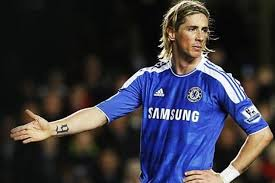

input image


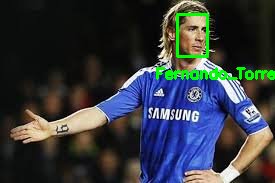

output image


In [24]:
classifcation_mtcnn('dataset/soccer-dataset/Fernando_Torres/torres7.jpg', model=model)

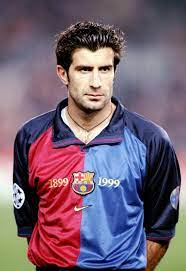

Found 1 faces!


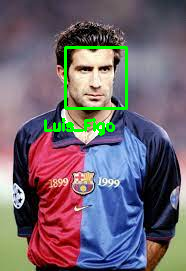

In [ ]:
classifcation_mtcnn('dataset/soccer-dataset/Luis_Figo/figo2.jpg', model=model)

## Similarity Testing

Input 2 images and check for their similarity.

In [25]:
# for sample_path in samples_pair_same:
#   similarity_mtcnn(sample_path[0], sample_path[1], model=model_embedding)

In [26]:
# for sample_path in samples_pair_diff:
#   similarity_mtcnn(sample_path[0], sample_path[1], model=model_embedding)

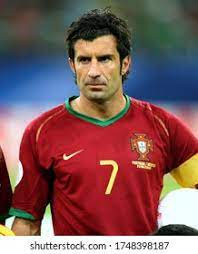

input image


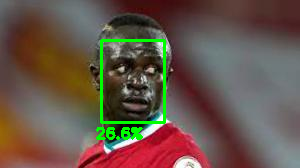

image to compare with input image


In [27]:
similarity_mtcnn('dataset/soccer-dataset/Luis_Figo/figo1.jpg', 'dataset/train-valid-test/test/Sadio_Mane/Sadio_Mane_0_9847.jpg', model=model_embedding)

# Video

## Create the labels

In [ ]:
labels = ['Alexandre_Lacazette',
 'Alexis_Sanchez',
 'Alisson_Becker',
 'Angel_di_Maria',
 'Antoine_Griezmann',
 'Bernando_Silva',
 'Bernd_Leno',
 'Carles_Puyol',
 'Carlos_Tevez',
 'Chrisitan_Pulisic',
 'Christian_Eriksen',
 'Cristiano_Ronaldo',
 'David_Beckham',
 'David_Luiz',
 'David_Silva',
 'Didier_Drogba',
 'Dries_Mertens',
 'Eden_Hazard',
 'Ederson_Moraes',
 'Falcao',
 'Fernando_Torres',
 'Frank_Lampard',
 'Freddie_Ljungberg',
 'Gabriel_Jesus',
 'Gareth_Bale',
 'Georginio_Wijnaldum',
 'Gerard_Pique',
 'Gianluigi_Buffon',
 'Giorgio_Chiellini',
 'Harry_Kane',
 'Harry_Kewell',
 'Heung_Min_Son',
 'Hugo_Lloris',
 'Iker_Casillas',
 'Jan_Oblak',
 'Javier_Mascherano',
 'Joao_Felix',
 'John_Terry',
 'Jose_Mourinho',
 'Julian_Draxler',
 'Jurgen_Klopp',
 'Kai_Havertz',
 'Kaka',
 'Kalidou_Koulibaly',
 'Karim_Benzema',
 'Kevin_de_Bruyne',
 'Kylian_Mbappe',
 'Leroy_Sane',
 'Lionel_Messi',
 'Lorenzo_Insigne',
 'Lucas_Moura',
 'Luis Suarez',
 'Luis_Figo',
 'Luka_Modric',
 'Manuel_Neuer',
 'Marc-Andre_ter_Stegen',
 'Marco_Reus',
 'Mario_Gotze',
 'Memphis_Depay',
 'Michael_Ballack',
 'Michael_Owen',
 'Mohammad_Salah',
 'Oliver_Giroud',
 'Oliver_Kahn',
 'Paul_Pogba',
 'Paulo_Dybala',
 'Pep_Guardiola',
 'Peter_Schmeichel',
 'Petr_Cech',
 'Philippe_Coutinho',
 'Pierre_Emerick_Aubameyang',
 'Raheem_Sterling',
 'Raul',
 'Robbie_Fowler',
 'Robert_Lewandowski',
 'Robert_Pires',
 'Roberto_Carlos',
 'Roberto_Firmino',
 'Romelu_Lukaku',
 'Ronaldinho',
 'Ronaldo',
 'Ryan_Giggs',
 'Sadio_Mane',
 'Sergio_Augero',
 'Sergio_Ramos',
 'Steven_Gerrard',
 'Thiago_Silva',
 'Thibaut_Courtois',
 'Thierry_Henry',
 'Thomas_Lemar',
 'Thomas_Muller',
 'Thomas_Tuchel',
 'Timo_Werner',
 'Toni_Kroos',
 'Vincent_Kompany',
 'Virgil_van_Dijk',
 'Wayne_Rooney',
 'Xabi_Alonso',
 'Zinedine_Zidane',
 'Zlatan_Ibrahimovic']

## Function for classification for video and computing similarily probabiliy with image as input and video as output

In [ ]:
def classifcation_video(video_path, video_writer_path, model):
  
  output_img = None


  # establish capture
  cap = cv2.VideoCapture(video_path)


  # get properties
  height = cap.get(cv2.CAP_PROP_FRAME_HEIGHT)
  width = cap.get(cv2.CAP_PROP_FRAME_WIDTH)
  fps = cap.get(cv2.CAP_PROP_FPS)
  # cap.get(cv2.CAP_PROP_FRAME_COUNT)


  # Video Writer
  # output_path = 'dataset/testing-dataset/video/video_out.mp4'
  output_path = video_writer_path

  Q = deque(maxlen=64)



  # importing cascade
  faceCascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")

  # fourcc stands for four char code
  fourcc = cv2.VideoWriter_fourcc(*'MP4V')
  vw = cv2.VideoWriter(output_path, fourcc, fps, (int(width), int(height)), True)

  # loop through each frame
  for frame_idx in range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))):

      success, img = cap.read() # capture frame from video



      # cv2_imshow(img)  
      


      # cv2 face cascades
      # Getting corners around the face
      # 1.3 = scale factor, 5 = minimum neighbor can be detected
      faces = faceCascade.detectMultiScale(img, 1.3, 5)  
      # # print("Found {0} faces!".format(len(faces)))

      # drawing bounding box around face
      for (x, y, w, h) in faces:
          img = cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 3)

          # coord to put text
          # img shape is height followed by width
          x_text = x - int(width*0.1) #  left 
          y_text = y + h + int(height*0.1) # btm

          # extract_face(filename=None, required_size=(224, 224), target=True, x=None, y=None, w=None, h=None)
          face_array = extract_face(x=x, y=y, h=h, w=w, target=True, img=img)
          
          face_array = face_array.astype('float32')
          # print(face_array)
          face_array /= 255
          # cv2_imshow(face_array)

          preds = model.predict(np.expand_dims(face_array, axis=0))[0]
          Q.append(preds)

          # perform prediction averaging over the current history of
          # previous predictions
          results = np.array(Q).mean(axis=0)
          i = np.argmax(results)
          label = labels[i]

          text = "{}".format(label)

          if preds[i] < 0.1:
            output_img = cv2.putText(img, 'Unknown', (x_text, y_text), cv2.FONT_HERSHEY_SIMPLEX, 
                      2, (0, 255, 0), 2)
            
          else:
            output_img = cv2.putText(img, text, (x_text, y_text), cv2.FONT_HERSHEY_SIMPLEX, 
                      2, (0, 255, 0), 2)

      if success:
        vw.write(output_img)

      else:
        break

  cap.release()
  vw.release()


def similarity_video(input_img_path, input_video_path, video_writer_path, model):


  face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')



  img_input_path = input_img_path
  cv2_imshow(cv2.imread(img_input_path))

  face_input = extract_face(filename=img_input_path, target=False)
  cv2_imshow(cv2.cvtColor(face_input, cv2.COLOR_BGR2RGB))


  cap = cv2.VideoCapture(input_video_path)

 
  # get properties
  height = cap.get(cv2.CAP_PROP_FRAME_HEIGHT)
  width = cap.get(cv2.CAP_PROP_FRAME_WIDTH)
  fps = cap.get(cv2.CAP_PROP_FPS)
  

  Q = deque(maxlen=128)

  # Video Writer
  output_path = video_writer_path


  # importing cascade
  faceCascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")

  # fourcc stands for four char code
  fourcc = cv2.VideoWriter_fourcc(*'MP4V')
  vw = cv2.VideoWriter(output_path, fourcc, fps, (int(width), int(height)), True)

 
  # loop through each frame
  for frame_idx in range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))):


    success, img_target = cap.read() # capture frame from video

    # cv2_imshow(img)

    # Detect faces
    faces = face_cascade.detectMultiScale(img_target, 1.3, 5)
    # print("Found {0} faces!".format(len(faces)))

    # Draw rectangle around the faces
    for (x, y, w, h) in faces:
        cv2.rectangle(img_target, (x, y), (x+w, y+h), (255, 0, 0), 2)


        x_text = x - int(224*0.05) #  left 
        y_text = y + h + int(224*0.15) # btm

        # extract_face(filename=None, required_size=(224, 224), target=True, x=None, y=None, w=None, h=None)
        face_target = extract_face(x=x, y=y, h=h, 
                                  w=w, target=True, img=img_target)
        # cv2_imshow(face_target)


        x_text = x - int(img_target.shape[1]*0.02)
        y_text = y + h + int(img_target.shape[0]*0.10)


        samples = get_embeddings([face_input, face_target])#, model=model_embedding)
        # print(faces_embedding)
        faces_embedding = model.predict(samples)
        cosine_similarity = similar_prob(faces_embedding[0], faces_embedding[1])

        # cv2_imshow(img_target)
        if cosine_similarity < 54.4:
          cv2.rectangle(img_target, (x, y), (x+w, y+h), (0, 255, 0), 2)
          text_color = (0, 255, 0)
        else:
          cv2.rectangle(img_target, (x, y), (x+w, y+h), (0, 0, 255), 2)
          text_color = (0, 0, 255)

        text = "{}%".format(cosine_similarity)
        img_target = cv2.putText(img_target, text, (x_text, y_text), cv2.FONT_HERSHEY_SIMPLEX, 
                      2, text_color, 2)


    if success:
      vw.write(img_target)

    else:
      break

  cap.release()
  vw.release()

## Classification Testing

Input a video and get a video output.

In [ ]:
input_video_path = 'dataset/testing-dataset/video/giggs_owen.mp4'
output_video_class_path = 'dataset/testing-dataset/video/video_out_class_model5.mp4'

In [ ]:
%%time
classifcation_video(input_video_path, output_video_class_path, model=model)

CPU times: user 3min 15s, sys: 1.89 s, total: 3min 16s
Wall time: 2min 4s


## Similarity Testing

Input an image and then get a video output.

In [ ]:
input_img_path_sim = 'dataset/soccer-dataset/Michael_Owen/owen2.jpg'
output_video_sim_path = 'dataset/testing-dataset/video/video_out_sim_model5_5percent.mp4'

### Person not trained in dataset

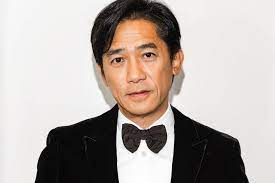

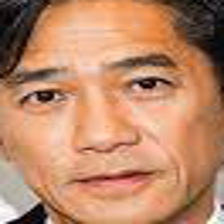

In [ ]:
# input_video_path = 'dataset/testing-dataset/video/tonyjacky.mp4'
# input_img_path_sim = 'dataset/testing-dataset/video/tony1.jpg'
# output_video_sim_path = 'dataset/testing-dataset/video/tonyjacky_out_sim_model5.mp4'
similarity_video('dataset/testing-dataset/video/tony1.jpg', 'dataset/testing-dataset/video/tony.mp4', 'dataset/testing-dataset/video/tony_out_sim_model5_5percent.mp4', model=model_embedding)

### Person trained in dataset

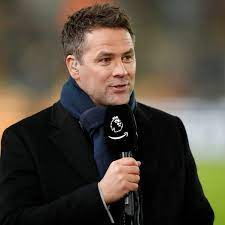

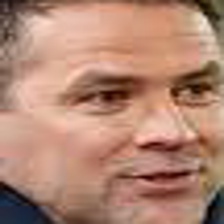

CPU times: user 8min 9s, sys: 5.16 s, total: 8min 14s
Wall time: 5min 19s


In [ ]:
%%time
similarity_video(input_img_path_sim, input_video_path, output_video_sim_path, model=model_embedding)